In [3]:
# imports
import simpy
from loguru import logger
import time
import numpy as np
import pandas as pd
import time, os
from itertools import chain
from cluster_simulator.cluster import Cluster, Tier, EphemeralTier, bandwidth_share_model, compute_share_model, get_tier, convert_size
from cluster_simulator.phase import DelayPhase, ComputePhase, IOPhase
from cluster_simulator.application import Application
from cluster_simulator.workflow import Workflow
from cluster_simulator.analytics import display_run

# imports for surrogate models
from sklearn.gaussian_process import GaussianProcessRegressor
import optuna

from workflow_optimizer.workflow_decomposer import WorkflowDecomposer
from workflow_optimizer.job_dependency_analyzer_nx import JobDependencyAnalyzerNX as JobDependencyAnalyzer

from loguru import logger
import json, sqlite3

# Remove default handlers
logger.remove()

# Add handler for level INFO and above
logger.add(lambda msg: print(msg, end=''), level="WARNING")

2

In [3]:
# Preparing json files for old format
import json

input_path = "/home_nfs/mimounis/iosea-wp3-recommandation-system/dataset_generation/dataset_deep/LQCD-BC/480592/volume.json"

output_path = "/home_nfs/mimounis/iosea-wp3-recommandation-system/dataset_generation/dataset_deep/LQCD-BC/480592/volume.json"

def transform_json_file_to_array_dynamically(input_path, output_path):
    # Load the original JSON data
    with open(input_path, 'r') as file:
        original_data = json.load(file)
    
    # Dynamically transform each JSON object into an array
    # Assumes all objects have the same structure
    if original_data:
        keys = list(original_data[0].keys())  # Extract keys from the first object
        transformed_data = [[entry[key] for key in keys] for entry in original_data]

        # Save the transformed data to a new file
        with open(output_path, 'w') as file:
            json.dump(transformed_data, file, indent=2)



transform_json_file_to_array_dynamically(input_path, output_path)


AttributeError: 'list' object has no attribute 'keys'

In [ ]:
OUTPUT_FOLDER="/home_nfs/mimounis/iosea-wp3-recommandation-system/workflow_optimizer/tests/data/decomposed_data"
WORKFLOW_FOLDER = "/home_nfs/mimounis/iosea-wp3-recommandation-system/dataset_generation/dataset_deep/LQCD-BC"
CLUSTER_CONFIG = "/home_nfs/mimounis/iosea-wp3-recommandation-system/workflow_optimizer/tests/data/cluster/config.yaml"

class WorkflowClusterOpt:
    experiment_data = []
    def __init__(self, 
                 workflow_folder=WORKFLOW_FOLDER, 
                 cluster_config=CLUSTER_CONFIG,
                 output_folder=OUTPUT_FOLDER):
        self.env = simpy.Environment()
        self.data = simpy.Store(self.env)
        
        wf_decomposer = WorkflowDecomposer(
            v0_threshold=0.01,
            workflow_name='ECMWF-649c3c40cc9340246f87cb58')
        decomposition_output = output_folder + wf_decomposer.workflow_name
        decomposed_data = wf_decomposer.decompose_workflow(
            output=decomposition_output)
        analyzer = JobDependencyAnalyzer(workflow_folder=WORKFLOW_FOLDER)
        analyzer.analyze_dependencies()
        dependencies_file = "/home_nfs/mimounis/iosea-wp3-recommandation-system/workflow_optimizer/tests/data/decomposed_data/ECMWF-649c3c40cc9340246f87cb58/dependencies.json"
        
        analyzer.dump_edges_to_json(file_path=dependencies_file)        


        # Function to parse JSON file
        def parse_json(file_path):
            with open(file_path, 'r') as file:
                return json.load(file)

        # feed jobs representations into Application instances
        self.jobs = {}
        for filename in os.listdir(decomposition_output):
            if 'representation' in filename:
                job_id = filename.split('_')[0]
                representation_data = parse_json(
                    os.path.join(decomposition_output, filename))

                # Assuming that 'Application' class takes these parameters
                self.jobs[job_id] = Application(
                    self.env, name=job_id, 
                    compute=representation_data["events"],
                    read=representation_data["read_volumes"],
                    write=representation_data["write_volumes"],
                    data=self.data)
                
        # Manage singleton jobs (with 1 point in IOI)
        self.dependencies = []
        dependency_job_names = set()
        for dep in parse_json(dependencies_file):
            job_from = dep[0]
            job_to = dep[1]
            dependency_job_names.add(job_from)  # Add the first job name
            dependency_job_names.add(job_to)  # Add the second job name
            dependency_type = dep[2]
            self.dependencies.append((job_from, job_to, dependency_type))

        missing_jobs = dependency_job_names - set(self.jobs.keys())

        # Fill missing jobs with a neutral/null Application instance
        for job_name in missing_jobs:
            self.jobs[job_name] = Application(self.env, name=job_name, 
                                        compute=[0], read=[0], write=[0],
                                        data=self.data)
            
        # Define cluster object
        self.cluster = Cluster(self.env, cluster_config)
        
        self.n_jobs = len(list(self.jobs.keys()))
        self.n_tiers = len(self.cluster.tiers)
        
        self.workflow = Workflow(self.env, self.jobs, self.dependencies, 
                                 self.cluster)
        
    def get_wf(self):
        return self.workflow
        
workflow = WorkflowClusterOpt().get_wf() 

In [4]:
OUTPUT_FOLDER="/home_nfs/mimounis/iosea-wp3-recommandation-system/workflow_optimizer/tests/data/decomposed_data"

wf_decomposer = WorkflowDecomposer(
            v0_threshold=0.01,
            workflow_name='LQCD-BC')
decomposition_output = OUTPUT_FOLDER + wf_decomposer.workflow_name
decomposed_data = wf_decomposer.decompose_workflow(
            output=decomposition_output)

In [5]:
job_representation = {"node_count": 1, "events": [0, 1, 28, 36, 62, 71, 78, 103, 129, 151, 155], "read_volumes": [0, 1208019997, 0, 0, 0, 0, 10856064778, 9485727084, 9664100288, 9664099190, 0], "read_bw": [0, 402673332.3333333, 0, 0, 0, 0, 1550866396.857143, 1897145416.8, 1610683381.3333333, 1932819838.0, 0], "write_volumes": [0, 0, 4831873362, 4831874585, 4525959168, 4831972604, 0, 0, 0, 0, 0], "write_bw": [0, 0, 483187336.2, 483187458.5, 502884352.0, 483197260.4, 0, 0, 0, 0, 0], "read_pattern": ["Uncl", "Seq", "Uncl", "Uncl", "Uncl", "Uncl", "Seq", "Seq", "Seq", "Seq", "Uncl"], "write_pattern": ["Uncl", "Uncl", "Seq", "Seq", "Seq", "Seq", "Uncl", "Uncl", "Uncl", "Uncl", "Uncl"], "read_operations": [0, 4619, 0, 0, 0, 0, 41718, 36479, 37166, 37166, 0], "write_operations": [0, 0, 18569, 18571, 17384, 18591, 0, 0, 0, 0, 0]}

In [6]:
import sys
sys.path.append("../") # go to parent dir
# imports
import simpy
from loguru import logger
import time
import numpy as np
import pandas as pd
from cluster_simulator.utils import convex_hull
from cluster_simulator.cluster import Cluster, Tier, EphemeralTier, bandwidth_share_model, compute_share_model, get_tier, convert_size
from cluster_simulator.phase import DelayPhase, ComputePhase, IOPhase
from cluster_simulator.application import Application
from cluster_simulator.analytics import display_run
#from cluster_simulator.ephemeral_placement import ClusterBlackBox
from cluster_simulator.analytics import *
import time

job_size = sum(job_representation["read_volumes"]) + sum(job_representation["write_volumes"])
print(f"Job size: {convert_size(job_size)}")

Job size: 59.9 GB


With SBB target on /p/project

WFID:							BC slurm ID		SBB flavor	datanodes
sbb-bm-2024-03-06-084038-ID0-2024-03-06_08:40:43	480592	 		high		4
sbb-bm-2024-03-06-093054-ID0-2024-03-06_09:31:00	480614			high		3
sbb-bm-2024-03-06-095844-ID0-2024-03-06_09:58:49	480625			high		2
sbb-bm-2024-03-06-110246-ID0-2024-03-06_11:02:52	480651			high		1

sbb-bm-2024-03-06-113426-ID0-2024-03-06_11:34:35	480670			medium		4
sbb-bm-2024-03-06-120544-ID0-2024-03-06_12:05:49	480692			medium		3
sbb-bm-2024-03-06-132332-ID0-2024-03-06_13:23:36	480699			medium		2
sbb-bm-2024-03-06-135038-ID0-2024-03-06_13:50:43	480713			medium		1

sbb-bm-2024-03-06-141616-ID0-2024-03-06_14:16:20	480727			small		4
sbb-bm-2024-03-06-150010-ID0-2024-03-06_15:00:15	480738			small		3
sbb-bm-2024-03-06-153056-ID0-2024-03-06_15:31:01	480748			small		2
sbb-bm-2024-03-06-162148-ID0-2024-03-06_16:21:52	480762			small		1


With SBB target on /afsm
sbb-bm-2024-03-04-150720-ID0-2024-03-04_15:07:24	479908			high		4
sbb-bm-2024-03-04-153706-ID0-2024-03-04_15:37:12	479915			high		3
sbb-bm-2024-03-04-171728-ID0-2024-03-04_17:17:34	479960			high		2
sbb-bm-2024-03-04-180008-ID0-2024-03-04_18:00:13	479979			high		1

sbb-bm-2024-03-04-222031-ID0-2024-03-04_22:20:37	480070			medium		4
sbb-bm-2024-03-05-095201-ID0-2024-03-05_09:52:07	480091			medium		3
sbb-bm-2024-03-05-130255-ID0-2024-03-05_13:03:01	480202			medium		2
sbb-bm-2024-03-05-134236-ID0-2024-03-05_13:42:40	480216			medium		1

sbb-bm-2024-03-05-142207-ID0-2024-03-05_14:22:14	480269			small		4
sbb-bm-2024-03-05-145536-ID0-2024-03-05_14:55:41	480317			small		3
sbb-bm-2024-03-05-153547-ID0-2024-03-05_15:35:51	480350			small		2
sbb-bm-2024-03-05-160519-ID0-2024-03-05_16:05:25	480371			small		1


In [8]:
sbb_p_project_bw = {'read':  {'seq': 400, 'rand': 400},
                        'write': {'seq': 295, 'rand': 295}}

p_project_bw = {'read':  {'seq': 250, 'rand': 250},
                    'write': {'seq': 100, 'rand': 100}}

sbb_afsm_bw = {'read':  {'seq': 400, 'rand': 400},
                        'write': {'seq': 96, 'rand': 96}}

afsm_bw = {'read':  {'seq': 300, 'rand': 300},
                        'write': {'seq': 95, 'rand': 95}}

tiers = {"afsm": [afsm_bw, sbb_afsm_bw],
         "p_project": [p_project_bw, sbb_p_project_bw]}

repr_length = len(job_representation["events"])

tier = "p_project"

print(f"tier: {tier}")
for sbb_size in [5e9, 10e9, 20e9, 30e9, 40e9, 50e9, 60e9, 70e9]:
#for sbb_size in [10e9, 100e9]:
    print(f"sbb_size: {sbb_size}")
    t_start = time.time()
    # sim env an data
    env = simpy.Environment()
    data = simpy.Store(env)
    

    # registering Tiers
    hdd_tier = Tier(env, tier + "_tier", max_bandwidth=tiers[tier][0], capacity=1e12)
    hdd_tier_destage = Tier(env, tier + "_tier", max_bandwidth=tiers[tier][0], capacity=1e12)
    sbb_tier = Tier(env, tier + "_tier", max_bandwidth=tiers[tier][1], capacity=1e12)
    
    bb = EphemeralTier(env, name='SBB_over_' + tier + "_tier", 
                       persistent_tier=hdd_tier_destage,
                       max_bandwidth=tiers[tier][1], 
                       capacity=sbb_size)

    # Define the cluster with 1 persistent and 1 ephemeral
    # cluster = Cluster(env, compute_nodes=3, cores_per_node=2, tiers=[hdd_tier, ssd_tier], ephemeral_tier=bb)
    cluster = Cluster(env, compute_nodes=2, cores_per_node=5,
                      tiers=[hdd_tier, sbb_tier],
                      ephemeral_tier=bb)

    volumes = [job_representation["read_volumes"][i] + 
            job_representation["write_volumes"][i] for i in range(repr_length)]

    use_sbb = [value <= sbb_size -10e9 for value in np.cumsum(volumes).tolist()]

    print(f"use_sbb: {use_sbb}")

    # Normalizing events to sampling period of 5s
    __SAMPLING_PERIOD__ = 5
    compute = [job_representation["events"][i]*__SAMPLING_PERIOD__ for i in range(repr_length)]
    #compute = [job_representation["events"][i]*__SAMPLING_PERIOD__ - j for i, j in zip(range(repr_length), np.cumsum([int(value)*__SAMPLING_PERIOD__ for value in use_sbb]))]

    app1 = Application(env, compute=compute,
                            read=job_representation["read_volumes"],
                            write=job_representation["write_volumes"],
                            data=data)

                            
    repr_length = len(job_representation["events"])
    # logger
    #env = simpy.Environment()
    logger.remove()
    t_start = time.time()
    # simulate the app execution
    t_start = time.time()
    #app1 = Application(env, compute=[0,  10], read=[1e9, 0], write=[0, 5e9], data=data)
    #app2 = Application(env, compute=[0, 5], read=[0, 2e9], write=[7e9, 0], data=data)
    #env.process(app1.run(cluster, placement=[0]*repr_length, use_bb=use_sbb))
    placement = [int(value) for value in use_sbb]
    print(f"placement: {placement}")
    env.process(app1.run(cluster, placement=[int(value) for value in use_sbb], use_bb=[0]*repr_length))
    #env.process(app1.run(cluster, placement=[int(value) for value in use_sbb], use_bb=use_sbb))

    env.run()

    print(f"application duration = {app1.get_fitness()}")
    # print(f"total simulation duration is about {time.time()-t_start}")
    # fig = display_run(data, cluster, width=800, height=900)
    # fig.show()

tier: p_project
sbb_size: 5000000000.0
use_sbb: [False, False, False, False, False, False, False, False, False, False, False]
placement: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
application duration = 1128.728842538
sbb_size: 10000000000.0
use_sbb: [True, False, False, False, False, False, False, False, False, False, False]
placement: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
application duration = 1126.9168125424999
sbb_size: 20000000000.0
use_sbb: [True, True, True, False, False, False, False, False, False, False, False]
placement: [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
application duration = 1063.037800689449
sbb_size: 30000000000.0
use_sbb: [True, True, True, True, True, False, False, False, False, False, False]
placement: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
application duration = 1001.1802855863982
sbb_size: 40000000000.0
use_sbb: [True, True, True, True, True, True, False, False, False, False, False]
placement: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
application duration = 984.8961884193982
sbb_size: 500000

In [9]:
t_start = time.time()
# sim env an data
env = simpy.Environment()
data = simpy.Store(env)
# tier perfs

sbb_p_project_bw = {'read':  {'seq': 400, 'rand': 400},
                        'write': {'seq': 95, 'rand': 95}}

p_project_bw = {'read':  {'seq': 250, 'rand': 250},
                    'write': {'seq': 100, 'rand': 100}}

sbb_afsm_bw = {'read':  {'seq': 400, 'rand': 400},
                        'write': {'seq': 96, 'rand': 96}}

afsm_bw = {'read':  {'seq': 300, 'rand': 300},
                        'write': {'seq': 95, 'rand': 95}}

# registering Tiers
hdd_tier = Tier(env, '/p/project/ tier', max_bandwidth=p_project_bw, capacity=1e12)
#hdd2_tier = Tier(env, 'HDD', max_bandwidth=hdd_bandwidth, capacity=1e12)
#ssd_tier = Tier(env, 'SSD', max_bandwidth=ssd_bandwidth, capacity=200e9)
sbb_p_project_tier = Tier(env, 'NVRAM', max_bandwidth=sbb_p_project_bw,
                          capacity=10e9)
# registering Ephemeral Tier
# bb = EphemeralTier(env, name="BB", persistent_tier=hdd_tier,
#                         bandwidth=nvram_bandwidth, capacity=10e9)
sbb_size = 20e9
print(f"sbb_size: {sbb_size}")

bb = EphemeralTier(env, name="BB", persistent_tier=hdd_tier,
                   max_bandwidth=sbb_p_project, 
                   capacity=sbb_size)

# Define the cluster with 1 persistent and 1 ephemeral
# cluster = Cluster(env, compute_nodes=3, cores_per_node=2, tiers=[hdd_tier, ssd_tier], ephemeral_tier=bb)
cluster = Cluster(env, compute_nodes=2, cores_per_node=5,
                  tiers=[hdd_tier, ssd_tier],
                  ephemeral_tier=bb)

volumes = [job_representation["read_volumes"][i] + 
           job_representation["write_volumes"][i] for i in range(repr_length)]

use_sbb = [value <= sbb_size for value in np.cumsum(volumes).tolist()]

print(f"use_sbb: {use_sbb}")

# Normalizing events to sampling period of 5s
__SAMPLING_PERIOD__ = 5
compute = [job_representation["events"][i]*__SAMPLING_PERIOD__ for i in range(repr_length)]

app1 = Application(env, name = "480592",
                        compute=compute,
                        read=job_representation["read_volumes"],
                        write=job_representation["write_volumes"],
                        data=data)

                        
repr_length = len(job_representation["events"])
# logger
#env = simpy.Environment()
logger.remove()
t_start = time.time()
# simulate the app execution
t_start = time.time()
#app1 = Application(env, compute=[0,  10], read=[1e9, 0], write=[0, 5e9], data=data)
#app2 = Application(env, compute=[0, 5], read=[0, 2e9], write=[7e9, 0], data=data)
env.process(app1.run(cluster, placement=[0]*repr_length, use_bb=use_sbb))

env.run()

print(f"application duration = {app1.get_fitness()}")

print(f"total simulation duration is about {time.time()-t_start}")
fig = display_run(data, cluster, width=800, height=900)
fig.show()

sbb_size: 20000000000.0


NameError: name 'sbb_p_project' is not defined

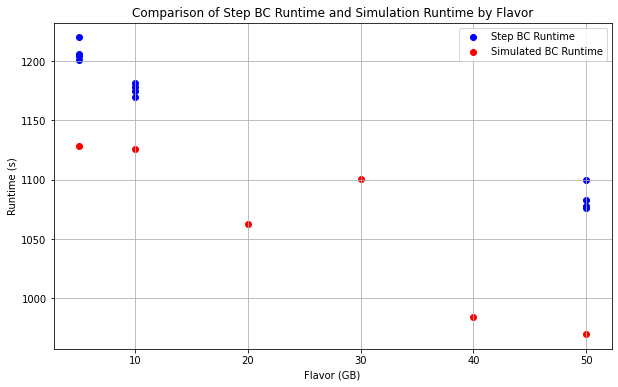

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# Define the CSV data as strings
csv_data = """
Flavor,Step BC Runtime (s)
50,1100
50,1083
50,1076
50,1078
10,1170
10,1175
10,1178
10,1182
5,1201
5,1204
5,1206
5,1220
"""
# tier: p_project
# sbb_size: 10000000000.0
# use_sbb: [True, False, False, False, False, False, False, False, False, False, False]
# placement: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# application duration = 1126.9168125424999
# sbb_size: 20000000000.0
# use_sbb: [True, True, True, False, False, False, False, False, False, False, False]
# placement: [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
# application duration = 1063.037800689449
# sbb_size: 30000000000.0
# use_sbb: [True, True, True, True, True, False, False, False, False, False, False]
# placement: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
# application duration = 1001.1802855863982
# sbb_size: 40000000000.0
# use_sbb: [True, True, True, True, True, True, False, False, False, False, False]
# placement: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
# application duration = 984.8961884193982
# sbb_size: 50000000000.0
# use_sbb: [True, True, True, True, True, True, True, False, False, False, False]
# placement: [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
# application duration = 970.6675977933983
# sbb_size: 60000000000.0
# use_sbb: [True, True, True, True, True, True, True, True, False, False, False]
# placement: [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
# application duration = 956.1714473613984
# sbb_size: 70000000000.0
# use_sbb: [True, True, True, True, True, True, True, True, True, True, True]
# placement: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
# application duration = 941.6752985763983
csv_data_2 = """
Flavor,Simulation Runtime (s)
5, 1128.8
10, 1126
20, 1063
30, 1101
40, 984
50, 970
"""

# Convert CSV data to DataFrames
data_1 = pd.read_csv(StringIO(csv_data), skipinitialspace=True)
data_2 = pd.read_csv(StringIO(csv_data_2), skipinitialspace=True)

# Plotting
plt.figure(figsize=(10, 6))

# Plotting the first dataset
plt.scatter(data_1['Flavor'], data_1['Step BC Runtime (s)'], color='blue', label='Step BC Runtime')

# Plotting the second dataset
plt.scatter(data_2['Flavor'], data_2['Simulation Runtime (s)'], color='red', label='Simulated BC Runtime')

plt.title('Comparison of Step BC Runtime and Simulation Runtime by Flavor')
plt.xlabel('Flavor (GB)')
plt.ylabel('Runtime (s)')
plt.legend()
plt.grid(True)

plt.show()


In [16]:
import plotly.graph_objects as go

# Update the second dataset with the new values
csv_data = """
Flavor,Step BC Runtime (s)
50,1100
50,1083
50,1076
50,1078
10,1170
10,1175
10,1178
10,1182
5,1201
5,1204
5,1206
5,1220
"""

csv_data_2 = """
Flavor,Simulation Runtime (s)
5, 1128.8
10, 1126
20, 1063
30, 1101
40, 984
50, 970
"""

# Re-convert the updated CSV data for the simulation runtime to ensure it's in the correct format
#0,1267 
#0, 1128.8
data_1 = pd.read_csv(StringIO(csv_data), skipinitialspace=True)
data_2_updated = pd.read_csv(StringIO(csv_data_2), skipinitialspace=True)

# Creating the Plotly figure
fig = go.Figure()

ref_value = 1 # 1 or 970
# Adding the Step BC Runtime scatter plot
fig.add_trace(go.Scatter(x=data_1['Flavor'], y=data_1['Step BC Runtime (s)']/ref_value,
                         mode='markers', name='Measured BC Runtime',
                         marker=dict(color='blue')))

# Adding the Simulation Runtime scatter plot with updated values
fig.add_trace(go.Scatter(x=data_2_updated['Flavor'], 
                         y=data_2_updated['Simulation Runtime (s)']/ref_value,
                         mode='markers', name='(RecSys) Simulation Runtime',
                         marker=dict(color='red')))

# Updating layout with titles, labels, and setting y-axis range
fig.update_layout(title='Comparison of Step BC (from LQCD) Runtime and Simulation Runtime by Flavor',
                  xaxis_title='Flavor (GB)',
                  yaxis_title='Runtime (s)',
                  yaxis=dict(range=[600/ref_value, 1300/ref_value]),  # Setting the span of y-axis
                  legend_title="Data for /p/project tier",
                  )

fig.show()


In [13]:
job_representation = {"node_count": 1, "events": [0, 1, 28, 36, 62, 71, 78, 103, 129, 151, 155], "read_volumes": [0, 1208019997, 0, 0, 0, 0, 10856064778, 9485727084, 9664100288, 9664099190, 0], "read_bw": [0, 402673332.3333333, 0, 0, 0, 0, 1550866396.857143, 1897145416.8, 1610683381.3333333, 1932819838.0, 0], "write_volumes": [0, 0, 4831873362, 4831874585, 4525959168, 4831972604, 0, 0, 0, 0, 0], "write_bw": [0, 0, 483187336.2, 483187458.5, 502884352.0, 483197260.4, 0, 0, 0, 0, 0], "read_pattern": ["Uncl", "Seq", "Uncl", "Uncl", "Uncl", "Uncl", "Seq", "Seq", "Seq", "Seq", "Uncl"], "write_pattern": ["Uncl", "Uncl", "Seq", "Seq", "Seq", "Seq", "Uncl", "Uncl", "Uncl", "Uncl", "Uncl"], "read_operations": [0, 4619, 0, 0, 0, 0, 41718, 36479, 37166, 37166, 0], "write_operations": [0, 0, 18569, 18571, 17384, 18591, 0, 0, 0, 0, 0]}

repr_length = len(job_representation["events"])

sbb_p_project_bw = {'read':  {'seq': 400, 'rand': 400},
                        'write': {'seq': 295, 'rand': 295}}

p_project_bw = {'read':  {'seq': 250, 'rand': 250},
                    'write': {'seq': 100, 'rand': 100}}

sbb_afsm_bw = {'read':  {'seq': 450, 'rand': 450},
                        'write': {'seq': 96, 'rand': 96}}

afsm_bw = {'read':  {'seq': 300, 'rand': 300},
                        'write': {'seq': 95, 'rand': 95}}

tiers = {"afsm": [afsm_bw, sbb_afsm_bw],
         "p_project": [p_project_bw, sbb_p_project_bw]}


tier = "p_project"

print(f"tier: {tier}")
for sbb_size in [0, 5e9, 10e9, 20e9, 30e9, 40e9, 50e9, 60e9, 70e9]:
#for sbb_size in [10e9, 100e9]:
    print(f"sbb_size: {sbb_size}")
    t_start = time.time()
    # sim env an data
    env = simpy.Environment()
    data = simpy.Store(env)
    

    # registering Tiers
    hdd_tier = Tier(env, tier + "_tier", max_bandwidth=tiers[tier][0], capacity=1e12)
    hdd_tier_destage = Tier(env, tier + "_tier", max_bandwidth=tiers[tier][0], capacity=1e12)
    sbb_tier = Tier(env, tier + "_tier", max_bandwidth=tiers[tier][1], capacity=1e12)
    
    # bb = EphemeralTier(env, name='SBB_over_' + tier + "_tier", 
    #                    persistent_tier=hdd_tier_destage,
    #                    max_bandwidth=tiers[tier][1], 
    #                    capacity=sbb_size)

    # Define the cluster with 1 persistent and 1 ephemeral
    # cluster = Cluster(env, compute_nodes=3, cores_per_node=2, tiers=[hdd_tier, ssd_tier], ephemeral_tier=bb)
    cluster = Cluster(env, compute_nodes=2, cores_per_node=5,
                      tiers=[hdd_tier, sbb_tier],)
                      #ephemeral_tier=bb)

    volumes = [job_representation["read_volumes"][i] + 
            job_representation["write_volumes"][i] for i in range(repr_length)]

    use_sbb = [value <= sbb_size -10e9 for value in np.cumsum(volumes).tolist()]

    print(f"use_sbb: {use_sbb}")

    # Normalizing events to sampling period of 5s
    __SAMPLING_PERIOD__ = 5
    compute = [job_representation["events"][i]*__SAMPLING_PERIOD__ for i in range(repr_length)]
    #compute = [job_representation["events"][i]*__SAMPLING_PERIOD__ - j for i, j in zip(range(repr_length), np.cumsum([int(value)*__SAMPLING_PERIOD__ for value in use_sbb]))]

    app1 = Application(env, compute=compute,
                            read=job_representation["read_volumes"],
                            write=job_representation["write_volumes"],
                            data=data)

                            
    
    # logger
    #env = simpy.Environment()
    logger.remove()
    t_start = time.time()
    # simulate the app execution
    t_start = time.time()
    #app1 = Application(env, compute=[0,  10], read=[1e9, 0], write=[0, 5e9], data=data)
    #app2 = Application(env, compute=[0, 5], read=[0, 2e9], write=[7e9, 0], data=data)
    #env.process(app1.run(cluster, placement=[0]*repr_length, use_bb=use_sbb))
    placement = [int(value) for value in use_sbb]
    print(f"placement: {placement}")
    env.process(app1.run(cluster, placement=[int(value) for value in use_sbb], use_bb=[0]*repr_length))
    #env.process(app1.run(cluster, placement=[int(value) for value in use_sbb], use_bb=use_sbb))

    env.run()

    print(f"application duration = {app1.get_fitness()}")
    # print(f"total simulation duration is about {time.time()-t_start}")
    # fig = display_run(data, cluster, width=800, height=900)
    # fig.show()

tier: p_project
sbb_size: 0
use_sbb: [False, False, False, False, False, False, False, False, False, False, False]
placement: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
application duration = 1128.728842538
sbb_size: 5000000000.0
use_sbb: [False, False, False, False, False, False, False, False, False, False, False]
placement: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
application duration = 1128.728842538
sbb_size: 10000000000.0
use_sbb: [True, False, False, False, False, False, False, False, False, False, False]
placement: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
application duration = 1126.9168125424999
sbb_size: 20000000000.0
use_sbb: [True, True, True, False, False, False, False, False, False, False, False]
placement: [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
application duration = 1063.037800689449
sbb_size: 30000000000.0
use_sbb: [True, True, True, True, True, False, False, False, False, False, False]
placement: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
application duration = 1001.1802855863982
sbb_size: 40000000000.0
u

### AFSM

In [17]:
import plotly.graph_objects as go

csv_data = """
Flavor,Step BC Runtime (s)
50,1081
50,1080
50,1082
50,1086
10,1080
10,1082
10,1081
10,1090
5,1094
5,1100
5,1103
5,1104
"""

# Update the second dataset with the new values
csv_data_2_updated = """
Flavor,Simulation Runtime (s)
5, 1111.488245358421
10, 1110.4815620275876
20, 1109.4219405421711
30, 1108.395851532083
40, 1099.34913088375
50, 1091.44435831375
"""

# Re-convert the updated CSV data for the simulation runtime to ensure it's in the correct format
data_1 = pd.read_csv(StringIO(csv_data), skipinitialspace=True)
data_2_updated = pd.read_csv(StringIO(csv_data_2_updated), skipinitialspace=True)

# Creating the Plotly figure
fig = go.Figure()

ref_value = 1080 #1 or 1080
# Adding the Step BC Runtime scatter plot
fig.add_trace(go.Scatter(x=data_1['Flavor'], y=data_1['Step BC Runtime (s)']/ref_value,
                         mode='markers', name='Measured BC Runtime',
                         marker=dict(color='blue')))

# Adding the Simulation Runtime scatter plot with updated values
fig.add_trace(go.Scatter(x=data_2_updated['Flavor'], 
                         y=data_2_updated['Simulation Runtime (s)']/ref_value,
                         mode='markers', name='(RecSys) Simulation Runtime',
                         marker=dict(color='red')))

# Updating layout with titles, labels, and setting y-axis range
fig.update_layout(title='Comparison of Step BC (from LQCD) Runtime and Simulation Runtime by Flavor',
                  xaxis_title='Flavor (GB)',
                  yaxis_title='Runtime (s)',   
                  yaxis=dict(range=[970/ref_value, 1150/ref_value]),  # Setting the span of y-axis
                  legend_title="Data for /afsm tier")

fig.show()
